In [1]:
#data and reps from here:
#https://github.com/henanjun/LCMR/blob/1/LCMR/LCMR_demo.m

#demo for LCMR to be appeared TGRS if you use code, please kind cite the paper, "A New Spatial-Spectral Feature Extraction Method for Hyperspectral Images Using Local Covariance Matrix Representation" Leyuan Fang et al. to be appeared TGRS

import sys
sys.path.append('./Hands')
from hand_utils import *
sys.path.append('./scripts')
import flag_dimensionality_reduction as fdr
from utils import *

from itertools import compress

from matplotlib import pyplot as plt
from geomstats.geometry.pre_shape import PreShapeSpace



class GeomstatsShapeSpace():
    """A simple adapter class which uses pymanopt language for geomstats shape space
    """

    def __init__(self, n, k):
        self._man = PreShapeSpace(m_ambient = n, k_landmarks = k)
        self._man.equip_with_group_action("rotations")
        self._man.equip_with_quotient_structure()

    def dist(self, point_a, point_b):
        return self._man.metric.dist(point_a, point_b)

    def exp(self, base_point, tangent_vector):
        return self._man.metric.exp(tangent_vector, base_point=base_point)

    def log(self, base_point, ambient_point):
        return self._man.to_tangent(ambient_point, base_point=base_point)
    
    def random_point(self):
        return self._man.random_point()


INFO: Using numpy backend


# Generate dataset with 40 hands and 30 ellipse outliers

In [3]:
n_outs = 30


# load data
filepath = './Hands/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T


shapes = []
for h in hands:
    k_shape = unmake_1d(h)
    k_shape = k_shape - np.mean(k_shape, axis = 0)
    k_shape = k_shape/np.linalg.norm(k_shape)
    shapes.append(k_shape)

shapes = shapes

for i in range(30):
    outlier = generate_ellipse_outlier(i+100)
    shapes.append(outlier)

labels = [0]*40 + [1]*n_outs

# Flagified Robust PCA Variant

We compute fWPCA on flattened hand data contaminated with 30 outliers. Then plot the objective function values and distance on the flag manifold between consecutive iterates of Algorithm 1 in the paper.

--------------------
iteration 0
objective 101.00925567187885
flag distance between B0 and B1 1.4065289529200016

--------------------
iteration 1
objective 99.87069918440783
flag distance between B0 and B1 0.18992274028531062

--------------------
iteration 2
objective 99.5187058230264
flag distance between B0 and B1 0.07854822906921

--------------------
iteration 3
objective 99.09588689990306
flag distance between B0 and B1 0.07723130383569482

--------------------
iteration 4
objective 98.39711405083321
flag distance between B0 and B1 0.09657377200413031

--------------------
iteration 5
objective 97.32611145732804
flag distance between B0 and B1 0.11581621813229724

--------------------
iteration 6
objective 96.10265249475785
flag distance between B0 and B1 0.11739558493193128

--------------------
iteration 7
objective 95.13868295445072
flag distance between B0 and B1 0.09225181376197497

--------------------
iteration 8
objective 94.06776786472176
flag distance between B0 and B1

Text(0.5, 1.0, 'Distance Between Iterates')

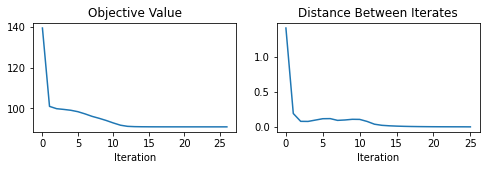

In [4]:
flat_data = np.vstack([d.flatten() for d in shapes]).T #features (random variables) are rows and points (samples) are columns

W_fpca, errs, cauchs   = fdr.flag_robust_pca(   flat_data,          # data set in R^n
                                                [1,2],              # flag type (nested subspace dimensions in increasing order)
                                                'wpca',             # robust pca variant
                                                max_iters = 200,    # max number of irls itertions
                                                init= 'rand',       # initialization type
                                                verbose = True,     # print progress at each iteration
                                                return_all = True)  # return more than the principal directions?


fig, [ax1, ax2] = plt.subplots(1,2, figsize = (8,2))

ax1.plot(errs)
ax1.set_xlabel('Iteration')
ax1.set_title('Objective Value')

ax2.plot(cauchs)
ax2.set_xlabel('Iteration')
ax2.set_title('Distance Between Iterates')

# Compare Flagified PCA variant to T-PCA

In [ ]:
manifold = GeomstatsShapeSpace(2,56)
fl_type = [1,2]

In [5]:
#compute median (for fW-TPCA, fR-TPCA, or fT-DPCP)
mean_seed = 21
median = fdr.karcher_median(manifold, shapes, seed = mean_seed)

In [6]:
[W_ftpca,_,_], ts_ftpca = fdr.flag_robust_tpca( manifold,            #the pymanopt manifold
                                                shapes,              #data as points on the manifold
                                                fl_type = fl_type,   #the flag type
                                                pca_type = 'dpcp',   #the PCA variant (wpca, rpca, or dpcp)
                                                return_ts = True,    #return the dataset and tangents to the median
                                                median = median,     #the karcher median
                                                init = 'rand',       #initialization choice
                                                rand_seed = 12345, #seed for reproducibility
                                                verbose = True)      #print algorithm progress at each iteration

--------------------
iteration 0
objective 0.12151365361165364
flag distance between B0 and B1 0.3446774373402149

--------------------
iteration 1
objective 0.12151365361165364
flag distance between B0 and B1 0.0



In [7]:
W_tpca, _, ts_tpca, mean =  PGA0(manifold,         #manifold as pymanopt object
                                shapes,           #data
                                [fl_type[-1]],    #number of PDs
                                return_ts = True, #return the dataset and tangents to the karcher mean
                                eps = 1e-9)       #convergence parameter for karcher mean

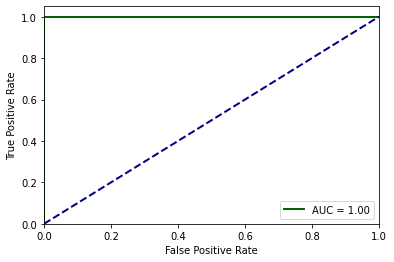

In [8]:
auc_ftpca, preds_ftpca, thresh_ftpca  = run_roc(shapes, W_ftpca, labels, 'dpcp', manifold, ts_ftpca, median, do_plots = True)

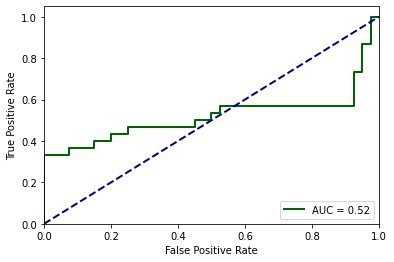

In [9]:
auc_tpca,  preds_tpca,  thresh_tpca  = run_roc(shapes, W_tpca, labels, 'pca', manifold, ts_tpca, mean, do_plots = True)

In [19]:
tpca_inlier_idx = preds_tpca <  thresh_tpca
ftpca_inlier_idx = preds_ftpca < thresh_ftpca


In [21]:
ftpca_shapes = list(compress(shapes, ftpca_inlier_idx))
tpca_shapes = list(compress(shapes, tpca_inlier_idx))

In [22]:
W_rec_ftpca, _, ts_rec_ftpca, mean_rec_ftpca =  PGA0( manifold, ftpca_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )
W_rec_tpca, _, ts_rec_tpca, mean_rec_tpca =  PGA0( manifold, tpca_shapes, [fl_type[-1]], return_ts = True, eps = 1e-9 )

In [23]:
err_ftpca, rec_data_ftpca  = reconst_err_man(manifold, mean_rec_ftpca, ftpca_shapes, ts_rec_ftpca, W_rec_ftpca, return_data= True)
err_tpca, rec_data_tpca  = reconst_err_man(manifold, mean_rec_tpca, ftpca_shapes, ts_rec_tpca, W_rec_tpca, return_data= True)

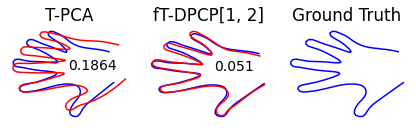

In [24]:

W=256
H=256

pt_num = 0

plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1,3, figsize = (6,2))

axs = axs.flatten()

interp_points = interp(shapes[pt_num])
axs[2].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
axs[2].set_title('Ground Truth')
axs[2].axis('off')

interp_points = interp(shapes[pt_num])
axs[0].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
interp_points = interp(rec_data_tpca[pt_num])
axs[0].plot(interp_points[0]*W,interp_points[1]*H, c = 'r')
axs[0].text(13,-2,np.round(err_tpca[pt_num],4))
axs[0].axis('off')
axs[0].set_title(f'T-PCA')

interp_points = interp(shapes[pt_num])
axs[1].plot(interp_points[0]*W,interp_points[1]*H, c = 'b')
interp_points = interp(rec_data_ftpca[pt_num])
axs[1].plot(interp_points[0]*W,interp_points[1]*H, c = 'r')
axs[1].text(13,-2,np.round(err_ftpca[pt_num],4))
axs[1].axis('off')
axs[1].set_title(f'fT-DPCP{fl_type}')
        
plt.tight_layout()

